In [4]:
# 변수 선언

MODEL_NAME = "skt/kogpt2-base-v2"
DATA_IN_PATH = "./datasets/"
DATA_OUT_PATH = "./models/"
TRAIN_DATA_FILE = "ko_slogans.csv"
TRAIN_DATA_NAME = "ko_slogans"
PLOT_OUT_PATH = "./plots/"

SEQ_LEN = 50

In [6]:
from transformers import PreTrainedTokenizerFast
from transformers import GPT2LMHeadModel

tokenizer = PreTrainedTokenizerFast.from_pretrained(MODEL_NAME)
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME)

model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [8]:
TOKENS_DICT = {
    'bos_token':'</s>',
    'eos_token':'</s>',
    'unk_token':'<unk>',
    'pad_token':'<pad>',
    'mask_token':'<mask>',
    'additional_special_tokens':['<context>', '<slogan>'],
}

# 특수 토큰이 토크나이저에 추가되고 모델은 수정된 토크나이저에 맞게 임베딩의 크기를 조정
tokenizer.add_special_tokens(TOKENS_DICT)
model.resize_token_embeddings(len(tokenizer))

print(tokenizer.special_tokens_map)
print(model.resize_token_embeddings(len(tokenizer)))

{'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'mask_token': '<mask>', 'additional_special_tokens': "['<context>', '<slogan>']"}
Embedding(51202, 768)


In [15]:
import csv
import torch
from torch.utils.data import Dataset

#학습용 데이터 로더
class SloganDataset(Dataset):
  def __init__(self, filename, tokenizer, seq_length=SEQ_LEN): # seq_length = 50

    context_tkn = tokenizer.additional_special_tokens_ids[0]  # 토크나이저의 additional_special_tokens_ids[0] : <context>
    slogan_tkn = tokenizer.additional_special_tokens_ids[1] # 토크나이저의 additional_special_tokens_ids[1] : <slogan>
    pad_tkn = tokenizer.pad_token_id  #'<pad>'
    eos_tkn = tokenizer.eos_token_id  # </s>

    self.examples = []  # example 빈리스트 생성
    with open(filename, 'r', encoding='UTF8') as csvfile:  # UTF8로 인코딩
      reader = csv.reader(csvfile)
      # ['company', 'slogan']
      # ['그린카', '그린카로 그리는 일상콘텐츠 ']
      # ['웨이브, 24시간 콘텐츠 스토어', '웨이브에 있었어 ']
      # ['삼성카드 카카오페이 신용카드', '귀여운 디자인에 그렇지 않은 혜택 '] ...
      
      for row in reader:
        # 컨텍스트 및 슬로건 세그먼트 구축
        context = [context_tkn] + tokenizer.encode(row[0], max_length=seq_length//2-1)
        # print(context) - [51200, 14005, 25306]
        # print(tokenizer.decode(context)) - <context> 하이마트
        slogan = [slogan_tkn] + tokenizer.encode(row[1], max_length=seq_length//2-2) + [eos_tkn]
        # print(context) - [51201, 11324, 414, 10553, 30254, 422, 431, 9815, 41427, 411, 739, 1]
        # print(tokenizer.decode(context)) - <slogan> OH HAPPY SALE </s>
        
        # 두 부분을 함께 연결
        tokens = context + slogan + [pad_tkn] * ( seq_length - len(context) - len(slogan) ) # 50 길이만큼 </pad>토큰 채움

        # 해당 세그먼트로 각 토큰에 주석달기 (읽을 수 있도록 주석달아줌)
        segments = [context_tkn] * len(context) + [slogan_tkn] * ( seq_length - len(context) )  
        # print(segments) - [51200, 51200, 51200, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201, 51201]
        # print(tokenizer.decode(segments)) - <context><context><context><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan><slogan>

        # 레이블을 -100으로 설정하여 컨텍스트, 패딩 및 <slogan> 토큰을 무시합니다.
        labels = [-100] * (len(context)+1) + slogan[1:] + [-100] * ( seq_length - len(context) - len(slogan) )
        #print(labels) - [-100, -100, -100, -100, 11324, 414, 10553, 30254, 422, 431, 9815, 41427, 411, 739, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]
        
        # 데이터셋에 전처리된 예제 추가
        self.examples.append((tokens, segments, labels)) #[토큰, 세그먼트, 라벨]
  
  def __len__(self):
    return len(self.examples)

  def __getitem__(self, item):
    return torch.tensor(self.examples[item])

# Build the dataset and display the dimensions of the 1st batch for verification:
# 데이터세트를 빌드하고 검증을 위해 첫 번째 배치의 차원을 표시:

slogan_dataset = SloganDataset(DATA_IN_PATH + TRAIN_DATA_FILE, tokenizer)
print(next(iter(slogan_dataset)).size())

torch.Size([3, 50])


In [17]:
import math, random

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# 훈련 및 검증 데이터 분할을 위한 인덱스 생성
indices = list(range(len(slogan_dataset)))

random.seed(42)
random.shuffle(indices)

split = math.floor(0.1 * len(slogan_dataset))
train_indices, val_indices = indices[split:], indices[:split]

# PyTorch 데이터 로더를 빌드
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(slogan_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(slogan_dataset, batch_size=64, sampler=val_sampler)
# 참고: 역전파(backprogation)가 포함되지 않으므로 유효성 검사를 위해 배치 크기를 두 배로 늘릴 수 있음(따라서 GPU 메모리에 맞음)

In [6]:
import numpy as np
from tqdm import tqdm
import os

def fit(model, optimizer, train_dl, val_dl, epochs=1, device=torch.device('cpu')):

  if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)
    print('--- Directory creation completed successfully ---')
  
  else:
    print('--- Directory already exists ---')
  
  # epoch당 average training loss를 track
  # epoch당 average validation loss를 track
  avg_train_losses = []
  avg_valid_losses = []
  
  for i in range(epochs):

    print(f'\n--- Starting epoch #{i+1} ---')

    model.train()
    
    # 한 epoch 동안 배치 손실과 배치 크기를 추적을 위한 리스트 생성
    losses = []
    nums = []

    for xb in tqdm(train_dl, desc="Training"):
      # 배치를 훈련 장치로 이동
      inputs = xb.to(device)

      # 토큰 ID, 세그먼트 ID 및 정답(레이블)을 사용하여 모델을 호출
      outputs = model(inputs[:,0,:], token_type_ids=inputs[:,1,:], labels=inputs[:,2,:])
      
      # 목록에 손실 및 배치 크기를 추가
      loss = outputs[0]
      losses.append(loss.item())
      nums.append(len(xb))

      loss.backward()

      optimizer.step()
      model.zero_grad()

    # 한 epoch 동안의 평균 비용을 계산
    train_cost = np.sum(np.multiply(losses, nums)) / sum(nums)
    train_loss = np.average(losses)
    avg_train_losses.append(train_loss)

    # 이제 유효성 검사를 위해 동일한 작업을 수행
    model.eval()
    
    with torch.no_grad():
      losses = []
      nums = []

      for xb in tqdm(val_dl, desc="Validation"):
        inputs = xb.to(device)
        outputs = model(inputs[:,0,:], token_type_ids=inputs[:,1,:], labels=inputs[:,2,:])
        losses.append(outputs[0].item())
        nums.append(len(xb))

    val_cost = np.sum(np.multiply(losses, nums)) / sum(nums)
    val_loss = np.average(losses)
    avg_valid_losses.append(val_loss)
    
    print(f'\n--- Epoch #{i+1} finished --- Training cost: {train_cost} / Validation cost: {val_cost}')
  
    if (i + 1) % 5 == 0 :
      torch.save(model.state_dict(), DATA_OUT_PATH + f'{i+1}epoch_model_weights.pth')
      print(f'\n--- Epoch #{i+1} Saving complete ! ---')
      
  return avg_train_losses, avg_valid_losses 


In [7]:
from transformers import AdamW

# Move the model to the GPU:
device = torch.device('cuda')
model.to(device)

# Fine-tune GPT2 for 5 epochs: 
optimizer = AdamW(model.parameters()) # 트랜스포머의 AdamW
train_loss, valid_loss = fit(model, optimizer, train_loader, val_loader, epochs=20, device=device)

Training:   0%|          | 0/272 [00:00<?, ?it/s]


--- Starting epoch #1 ---


Training:   0%|          | 1/272 [00:00<00:30,  8.84it/s]


--- Epoch #1 finished --- Training cost: 6.5908012699543255 / Validation cost: 5.81511555656868

--- Starting epoch #2 ---


Training:   0%|          | 1/272 [00:00<00:30,  8.92it/s]


--- Epoch #2 finished --- Training cost: 5.312199634722285 / Validation cost: 4.974470997597887

--- Starting epoch #3 ---


Training:   0%|          | 1/272 [00:00<00:46,  5.84it/s]


--- Epoch #3 finished --- Training cost: 4.525970102727989 / Validation cost: 4.474955073045326

--- Starting epoch #4 ---


Training:   0%|          | 1/272 [00:00<00:30,  8.93it/s]


--- Epoch #4 finished --- Training cost: 3.9482218796791044 / Validation cost: 4.0663905929407305

--- Starting epoch #5 ---


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.75it/s]



--- Epoch #5 finished --- Training cost: 3.492918441222112 / Validation cost: 3.860727627907392


Training:   0%|          | 1/272 [00:00<00:31,  8.61it/s]


--- Epoch #5 saving --- 

--- Starting epoch #6 ---


Training:   0%|          | 1/272 [00:00<00:31,  8.61it/s]


--- Epoch #6 finished --- Training cost: 3.2028638661538626 / Validation cost: 3.727544149092442

--- Starting epoch #7 ---


Training:   0%|          | 1/272 [00:00<00:33,  8.19it/s]


--- Epoch #7 finished --- Training cost: 3.023148222557696 / Validation cost: 3.7617686736151343

--- Starting epoch #8 ---


Training:   0%|          | 1/272 [00:00<00:30,  9.00it/s]


--- Epoch #8 finished --- Training cost: 2.898653427247786 / Validation cost: 3.67916764175336

--- Starting epoch #9 ---


Training:   0%|          | 1/272 [00:00<00:30,  9.00it/s]


--- Epoch #9 finished --- Training cost: 2.7687380180016565 / Validation cost: 3.689613899912859

--- Starting epoch #10 ---


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s]



--- Epoch #10 finished --- Training cost: 2.7699443959334014 / Validation cost: 3.6733698780672537


Training:   0%|          | 1/272 [00:00<00:32,  8.40it/s]


--- Epoch #10 saving --- 

--- Starting epoch #11 ---


Training:   0%|          | 1/272 [00:00<00:29,  9.08it/s]


--- Epoch #11 finished --- Training cost: 2.5556623468298105 / Validation cost: 3.601106362021649

--- Starting epoch #12 ---


Training:   0%|          | 1/272 [00:00<00:30,  9.00it/s]


--- Epoch #12 finished --- Training cost: 2.5082576340703002 / Validation cost: 3.6970809763577317

--- Starting epoch #13 ---


Training:   0%|          | 1/272 [00:00<00:30,  9.00it/s]


--- Epoch #13 finished --- Training cost: 2.8504020984525016 / Validation cost: 3.8301006154075186

--- Starting epoch #14 ---


Training:   0%|          | 1/272 [00:00<00:29,  9.17it/s]


--- Epoch #14 finished --- Training cost: 2.9849648099312076 / Validation cost: 3.8157427209646593

--- Starting epoch #15 ---


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.20it/s]



--- Epoch #15 finished --- Training cost: 3.0669840029511537 / Validation cost: 3.9376793073248986


Training:   0%|          | 1/272 [00:00<00:45,  5.98it/s]


--- Epoch #15 saving --- 

--- Starting epoch #16 ---


Training:   0%|          | 1/272 [00:00<00:30,  8.77it/s]


--- Epoch #16 finished --- Training cost: 3.1451464866747023 / Validation cost: 3.983180765784466

--- Starting epoch #17 ---


Training:   0%|          | 1/272 [00:00<00:31,  8.69it/s]


--- Epoch #17 finished --- Training cost: 3.1104198763900457 / Validation cost: 4.4682307737478935

--- Starting epoch #18 ---


Training:   0%|          | 1/272 [00:00<00:31,  8.55it/s]


--- Epoch #18 finished --- Training cost: 3.3206699431024824 / Validation cost: 3.8942397740220778

--- Starting epoch #19 ---


Training:   0%|          | 1/272 [00:00<00:29,  9.08it/s]


--- Epoch #19 finished --- Training cost: 3.716760035763673 / Validation cost: 4.314213627731244

--- Starting epoch #20 ---


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s]



--- Epoch #20 finished --- Training cost: 3.8953421452711434 / Validation cost: 4.597691911242786

--- Epoch #20 saving --- 


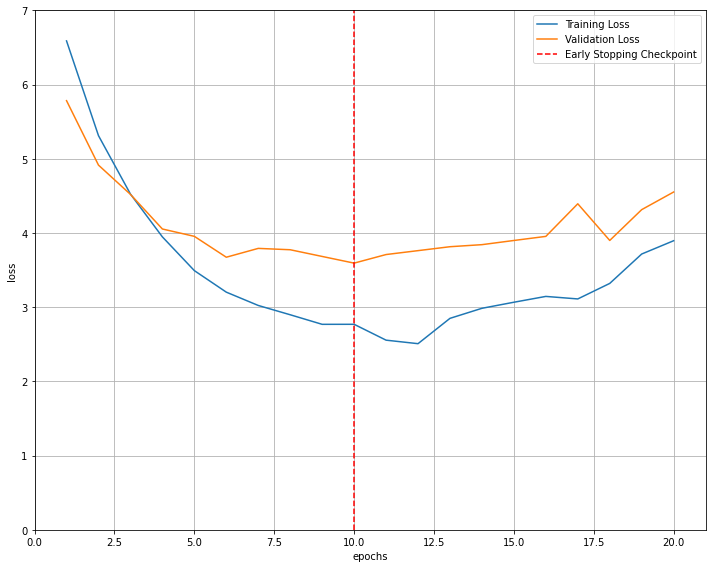

--- Directory already exists ---


In [53]:
import matplotlib.pyplot as plt


# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(valid_loss) + 1), valid_loss, label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss)) + 1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 7) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

if not os.path.exists(PLOT_OUT_PATH):
    os.makedirs(PLOT_OUT_PATH)
    print('--- Directory creation completed successfully ---')
    
else:
    print('--- Directory already exists ---')

fig.savefig( PLOT_OUT_PATH + TRAIN_DATA_NAME + '_loss_plot.png', bbox_inches = 'tight')